In [828]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Import Libraries

In [1114]:
import pandas as pd
import numpy as np
from pandas import DataFrame as df
import matplotlib.pyplot as plt
%matplotlib inline
import re
import operator
import ast
import warnings
import seaborn as sns
import pandas_profiling as pp

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import * 

from scipy.special import expit
import statsmodels.api as sm

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

import matplotlib.pyplot as plt
from itertools import cycle

from datetime import datetime

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (8,8)

# Import Data

In [367]:
Fraud_data = pd.read_csv("Fraud_Data.csv",low_memory=False)
IP_Add = pd.read_csv("IpAddress_to_Country.csv",low_memory=False)
print(Fraud_data.head())
print(IP_Add.head())

   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  
   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China


In [366]:
#Data types
print(Fraud_data.info(null_counts=True,verbose=True))
print(IP_Add.info(null_counts=True,verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB
None


In [5]:
#No Null values! 
print(Fraud_data.isnull().sum())
print(IP_Add.isnull().sum())

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64


In [1193]:
#Lower_bound_ip_address was imported as float64 instead of int64. Previous cell indicates no null types, 
#so following command is a check to determine if there are IP addresses that have a nonzero digit after decimal places.
print("# of bad lower bound IP addresses: ",sum(IP_Add.lower_bound_ip_address.astype(np.int64)/IP_Add.lower_bound_ip_address!=1.0))
print("# of float IP addresses: ",sum(Fraud_data.ip_address.astype(np.int64)/Fraud_data.ip_address!=1.0))

#Convert to float64 to ensure working with identical data types
IP_Add.upper_bound_ip_address= IP_Add.upper_bound_ip_address.astype('float64',inplace=True)
print(IP_Add.dtypes)
print(Fraud_data.ip_address.dtype)

# of bad lower bound IP addresses:  0
# of float IP addresses:  151111
lower_bound_ip_address    float64
upper_bound_ip_address    float64
country                    object
dtype: object
float64


## Joining IP Address table data with Fraud Data via IP Addresses

In [530]:
Fraud_data['country']=Fraud_data.ip_address.map(lambda x : IP_Add[(x<=IP_Add['upper_bound_ip_address']) & (x>=IP_Add['lower_bound_ip_address'])].country.values)

In [369]:
Fraud_data['country'].head()   #Must remove brackets

0            [Japan]
1    [United States]
2    [United States]
3                 []
4    [United States]
Name: country, dtype: object

In [1194]:
print('shape=',Fraud_data['country'].shape)

shape= (151112,)


In [531]:
#Function needed to remove brackets from each country in country column of Fraud Data. Returns "Missing" for blank items
def extract(item):
    try:                         #Many of the IP addresses the in dataset do not have a country of origin in IP addresses table. 
        item[0]
        return item[0]
    except:
        return "Missing"


In [532]:
Fraud_data['country']=Fraud_data['country'].map(extract)

In [1195]:
Fraud_data['country'].head()

0            Japan
1    United States
2    United States
3          Missing
4    United States
Name: country, dtype: object

In [533]:
#Convert Sign up time and purchase time to datetime objects
Fraud_data['signup_time']= pd.to_datetime(Fraud_data['signup_time'])
Fraud_data['purchase_time']= pd.to_datetime(Fraud_data['purchase_time'])

#Create a variable for the delta between signup time and purchase time since this can be indicative of fraud 
Fraud_data['delta_time_minutes']= (Fraud_data['purchase_time']-Fraud_data['signup_time']).dt.total_seconds()/60

# Univariate Analysis

In [387]:
cont_cols = ['age','purchase_value','delta_time_minutes']
cat_cols = ['source','browser','country','sex']
output=['class']

In [196]:
describe_list = []
for c in cont_cols:
    describe_list.append(Fraud_data[c].describe())
        
describeDF = pd.DataFrame(describe_list, columns = describe_list[0].index)

describeDF.sort_values('count', ascending = False)

,count,mean,std,min,25%,50%,75%,max
age,151112.0,33.140704,8.617733,18.000000,27.000000,33.000000,39.000000,76.000000
purchase_value,151112.0,36.935372,18.322762,9.000000,22.000000,35.000000,49.000000,154.000000
delta_time_minutes,151112.0,82200.487477,52104.385307,0.016667,36445.891667,82105.758333,127408.741667,172799.533333


In [610]:
#Data is provided for only Year 2015
print(Fraud_data['purchase_time'].dt.year.describe())
print(Fraud_data['signup_time'].dt.year.describe())


count    151112.0
mean       2015.0
std           0.0
min        2015.0
25%        2015.0
50%        2015.0
75%        2015.0
max        2015.0
Name: purchase_time, dtype: float64
count    151112.0
mean       2015.0
std           0.0
min        2015.0
25%        2015.0
50%        2015.0
75%        2015.0
max        2015.0
Name: signup_time, dtype: float64


# Histogram of continuous columns.

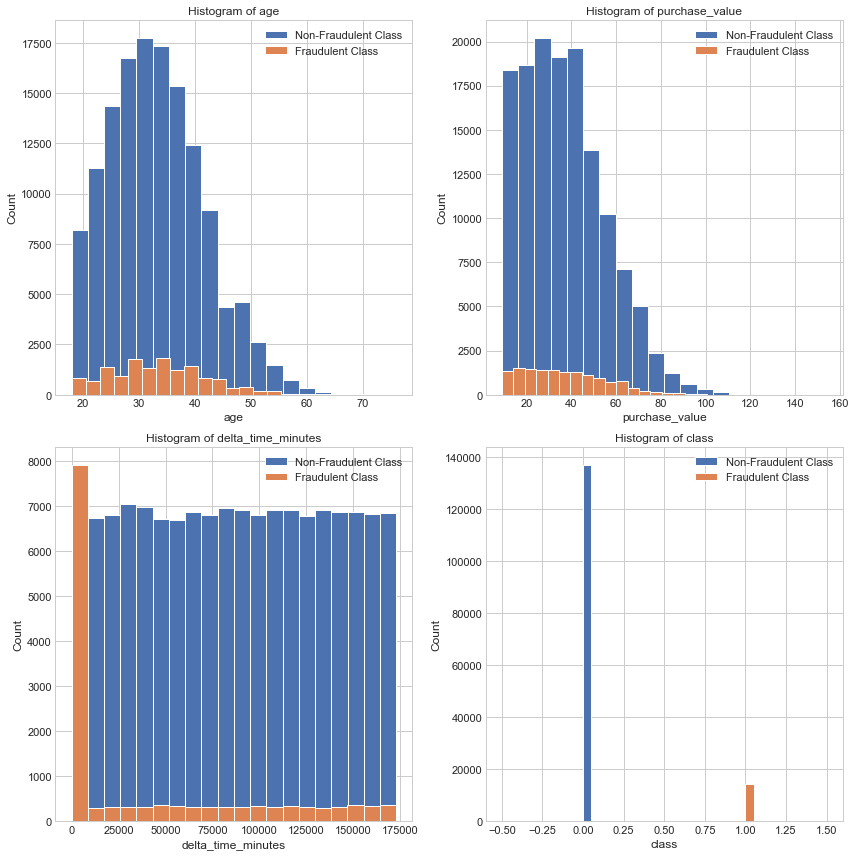

In [510]:
fig, axes = plt.subplots(round(len(Fraud_data[cont_cols + output].columns)/2), 2)

for i, ax in enumerate(fig.axes):
    ax.hist(Fraud_data[Fraud_data['class']==0][columns[i]],bins=20)
    ax.hist(Fraud_data[Fraud_data['class']==1][columns[i]],bins=20)
    ax.set_xlabel(columns[i])
    ax.set_ylabel('Count')
    ax.set_title('Histogram of '+columns[i])
    ax.legend(['Non-Fraudulent Class','Fraudulent Class'],loc="upper right")
    fig.set_size_inches(12,12)
fig.tight_layout()


# Output summary
### 1)Seems that output class has significant class imbalance. Oversampling methods should be considered following the baseline model to attempt to improve model output. 

### 2)delta_time_minutes histogram seems to indicate uniform distribution except for at small delta_time_minutes values, where there seems to be a huge spike for the positive class

### 3)It is difficult to compare distributions of age and purchase_value between both classes due to class imbalance (height of the bars between both classes are different by orders of magnitude) . Replot with Density plots in order to compare distributions.

# Density plot of continuous variables

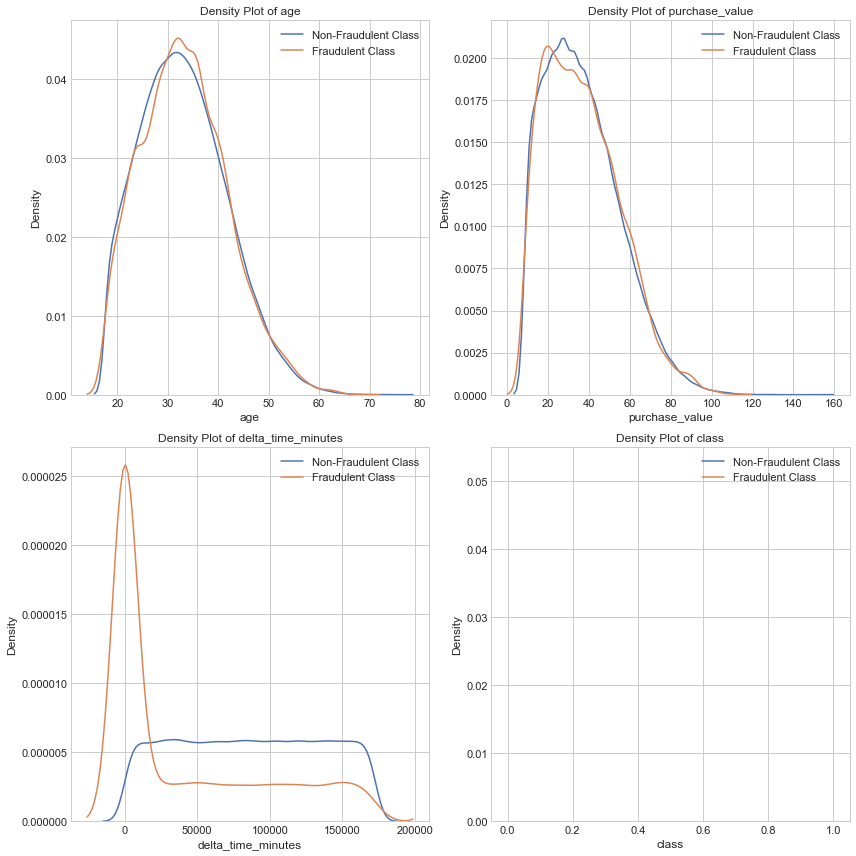

In [522]:
fig, axes = plt.subplots(round(len(Fraud_data[cont_cols + output].columns)/2), 2)

for i, ax in enumerate(fig.axes):
    sns.distplot(Fraud_data[Fraud_data['class']==0][columns[i]],ax=ax,hist=False,label='Non-Fraudulent Class')
    sns.distplot(Fraud_data[Fraud_data['class']==1][columns[i]],ax=ax,hist=False,label='Fraudulent Class')
    ax.set_xlabel(columns[i])
    ax.set_ylabel('Density')
    ax.set_title('Density Plot of '+columns[i])
    ax.legend(['Non-Fraudulent Class','Fraudulent Class'],loc="upper right")
    fig.set_size_inches(12,12)
fig.tight_layout()


## Output Summary
### 1) For fraudulent accounts, it seems very apparent that majority of fraud accounts occur at small values of delta_time_minutes

### 2) The difference in distributions of variables 'purchase value' and 'age' for fraudulent and non-fraudulent accounts is minimal. Consequently, it is expected that these two variables do not significantly contribute to the prediction of Fraud. 

# Distributions of "Purchase Time" or "Sign-Up Time" variables

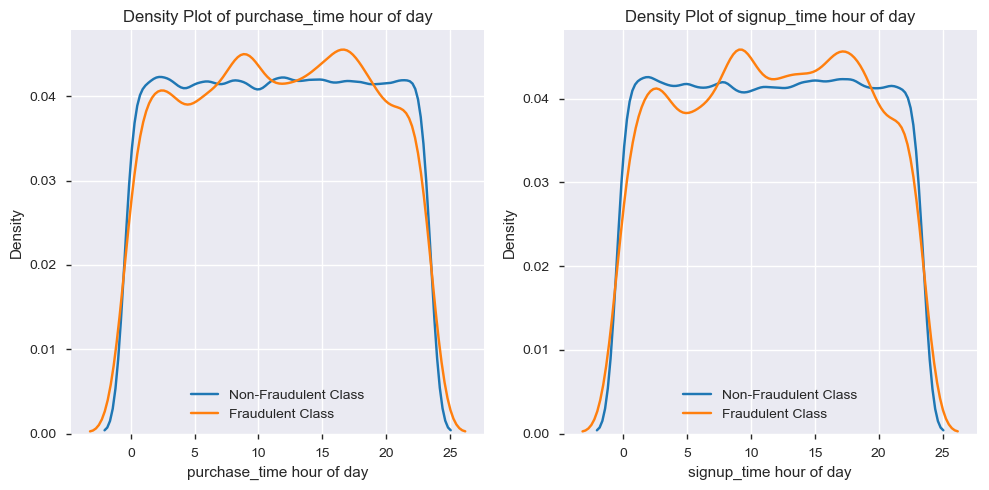

In [572]:
columns=['purchase_time','signup_time']
fig, axes = plt.subplots(1, 2)

for i, ax in enumerate(fig.axes):
    sns.distplot(Fraud_data[Fraud_data['class']==0][columns[i]].dt.hour,ax=ax,hist=False,label='Non-Fraudulent Class')
    sns.distplot(Fraud_data[Fraud_data['class']==1][columns[i]].dt.hour,ax=ax,hist=False,label='Fraudulent Class')
    ax.set_xlabel(columns[i]+ " hour of day")
    ax.set_ylabel('Density')
    ax.set_title('Density Plot of '+columns[i]+" hour of day")
    ax.legend(['Non-Fraudulent Class','Fraudulent Class'])
    fig.set_size_inches(10,5)
fig.tight_layout()


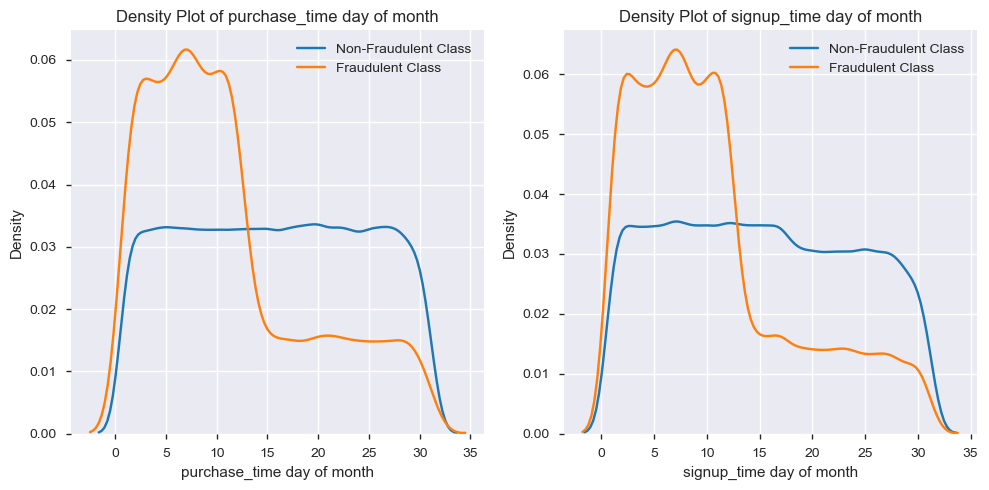

In [575]:
columns=['purchase_time','signup_time']
fig, axes = plt.subplots(1, 2)

for i, ax in enumerate(fig.axes):
    sns.distplot(Fraud_data[Fraud_data['class']==0][columns[i]].dt.day,ax=ax,hist=False,label='Non-Fraudulent Class')
    sns.distplot(Fraud_data[Fraud_data['class']==1][columns[i]].dt.day,ax=ax,hist=False,label='Fraudulent Class')
    ax.set_xlabel(columns[i]+ " day of month")
    ax.set_ylabel('Density')
    ax.set_title('Density Plot of '+columns[i]+" day of month")
    ax.legend(['Non-Fraudulent Class','Fraudulent Class'])
    fig.set_size_inches(10,5)
fig.tight_layout()


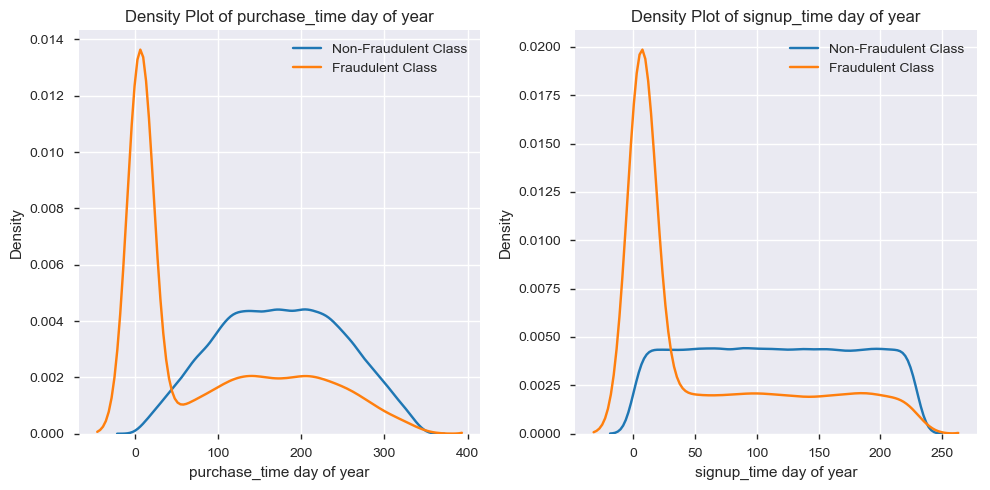

In [581]:
columns=['purchase_time','signup_time']
fig, axes = plt.subplots(1, 2)

for i, ax in enumerate(fig.axes):
    sns.distplot(Fraud_data[Fraud_data['class']==0][columns[i]].dt.dayofyear,ax=ax,hist=False,label='Non-Fraudulent Class')
    sns.distplot(Fraud_data[Fraud_data['class']==1][columns[i]].dt.dayofyear,ax=ax,hist=False,label='Fraudulent Class')
    ax.set_xlabel(columns[i]+ " day of year")
    ax.set_ylabel('Density')
    ax.set_title('Density Plot of '+columns[i]+" day of year")
    ax.legend(['Non-Fraudulent Class','Fraudulent Class'])
    fig.set_size_inches(10,5)
fig.tight_layout()


## Output summary

### 1) Previous two plots suggest that when the 'day of month' is less than 15 amongst Fraudulent class, Fraud increases. However, 'Day of Year' plot suggests that most  of the of the Fraudulent class is grouped at the beginning of the year. Therefore, must plot histogram showing distribution of months associated with fraudulent class when day of month is less than 15. This may help to overlook "day of month" variable.

### 2) Hour of Day density plot suggests there is no significant difference amongst distribution of Hour of day amongst Fraudulent class and Non-Fraudulent class

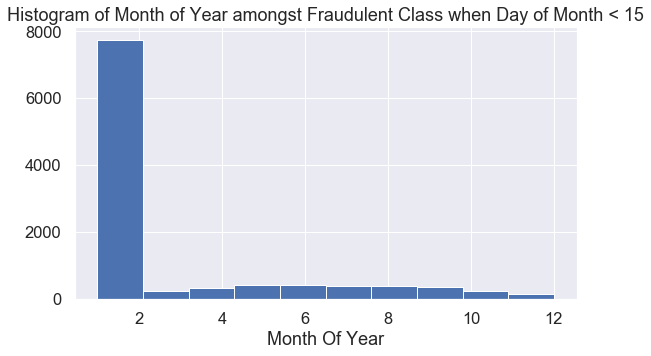

In [1221]:
#Histogram of Purchase month when day of month of purchase is less than 15. This purpose of this plot is to illustrate correlation between these two variables. 

Fraud_data[Fraud_data['class']==1][Fraud_data[Fraud_data['class']==1]['purchase_time'].dt.day<15]['purchase_time'].dt.month.hist()
plt.xlabel("Month Of Year")
plt.title("Histogram of Month of Year amongst Fraudulent Class when Day of Month < 15")
plt.rcParams["figure.figsize"] = (6,4)
plt.show()

## Output summary

### 1) It seems that both "day of month" and "day of year" shows significant differences in density distribution amongst the positive and negative class. However, histogram of 'Month of year' amongst Fraudulent Class when day of month < 15' suggests that most of the months are clustered at the beginning of year, suggesting we can ignore "Day of Month" variable. Therefore, will include "day of year" of "Purchase Time" as an important variable in data.



In [705]:
#Creating variable for "DayofYear"
Fraud_data['DayOfYear']=Fraud_data['purchase_time'].dt.dayofyear

In [706]:
Fraud_data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'delta_time_minutes', 'DayOfYear'],
      dtype='object')

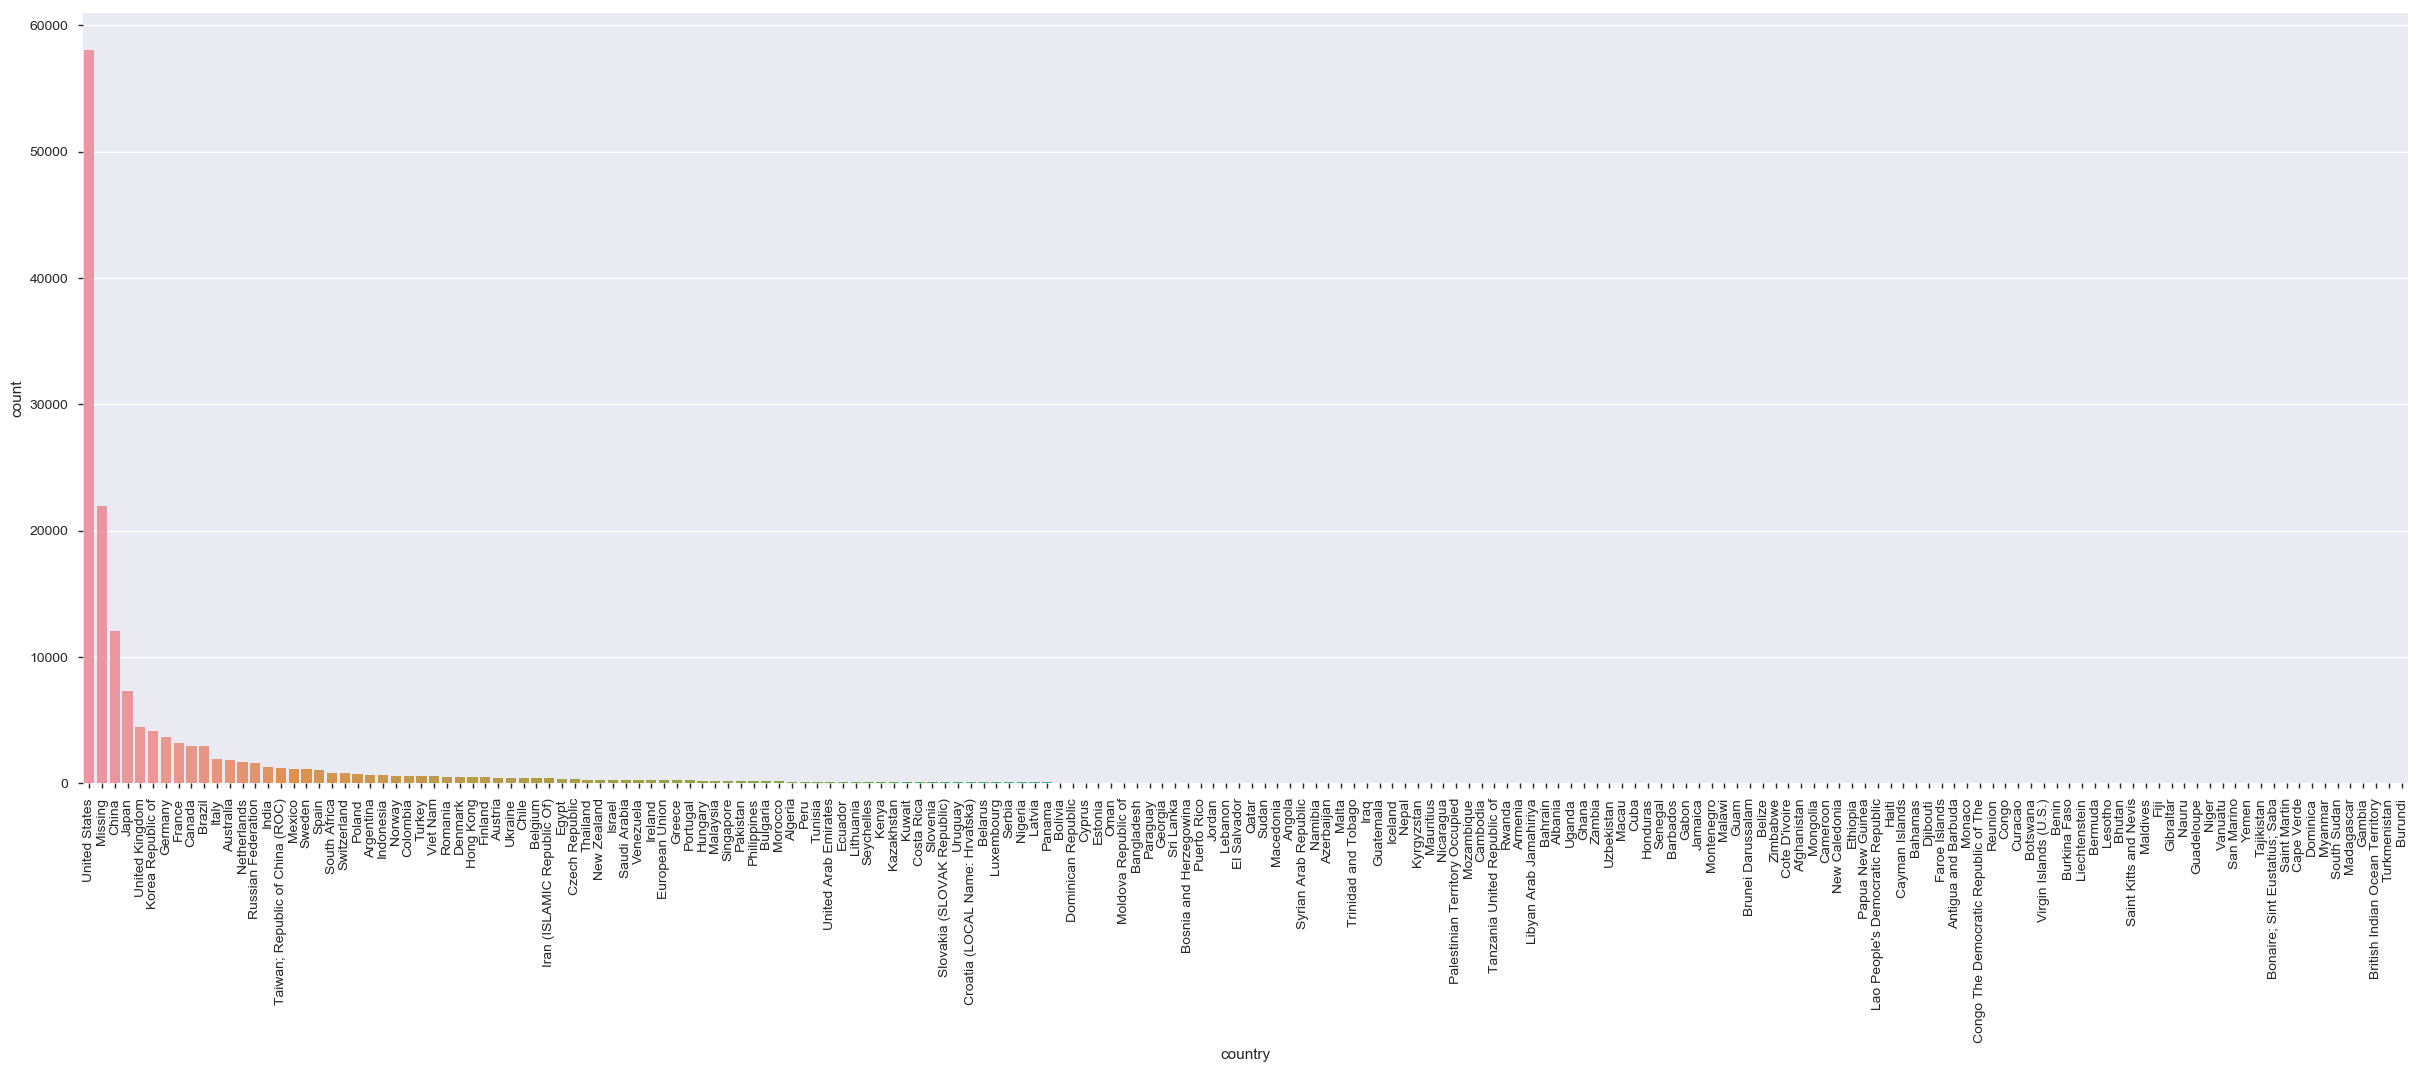

Number of Countries represented in data: 182


In [832]:
#Count plot of countries in data. Notice that "Missing" is the second highest count.

g=sns.countplot(x='country', data=Fraud_data,order = Fraud_data['country'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
plt.show()


print("Number of Countries represented in data:",len(Fraud_data.country.unique()))

### The bar graph from above indicates that there are 182 countries, but most of the countries are not well-represented in the dataset (i.e have very small counts), therefore, will reduce the number of countries represented in the dataset by only using all the countries representing 95% of the distribution. The "low-count" countries will be given the name "Other". 

In [834]:
#Countries that make up 95% of the distribution
MajorityCountries= Fraud_data.country.value_counts()[Fraud_data.country.value_counts(normalize=True).cumsum()<0.95].index
print("Number of Countries represented in new data:",len(MajorityCountries))

Number of Countries represented in new data: 36


In [846]:
#Transforming "country" column to only include countries that comprise 95% of distribution. "Pruned" countries will be labeled as "Other" 
Fraud_data['Reduced_countries']='Other'
Fraud_data['country']=Fraud_data['Reduced_countries'].mask(Fraud_data['country'].isin(MajorityCountries), Fraud_data['country'])
Fraud_data.drop('Reduced_countries',axis=1,inplace=True)

# Distribution of categorical variables

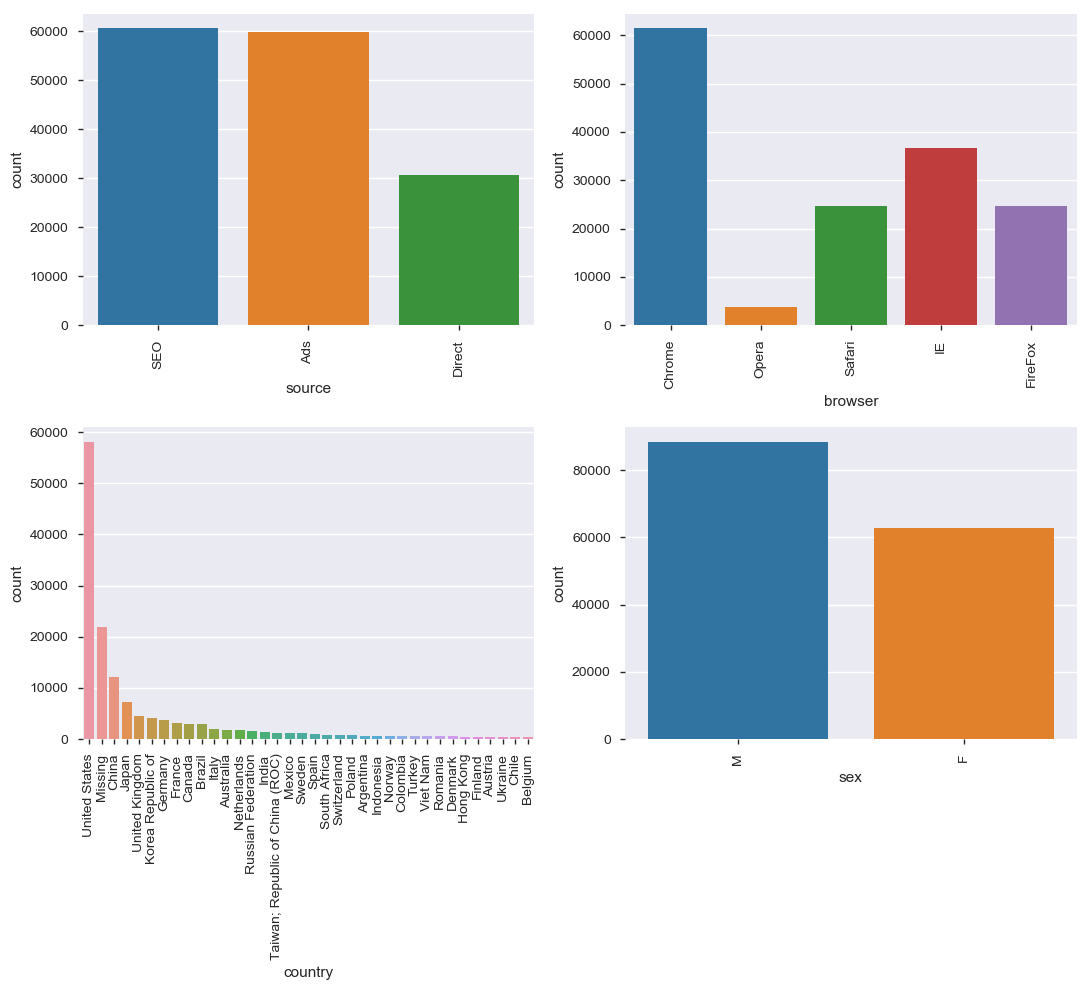

In [847]:


fig, axes = plt.subplots(2, 2, figsize=(11, 2.5*round(len(Fraud_data[cat_cols].columns))))

for i, ax in enumerate(fig.axes):
    if Fraud_data[cat_cols].columns[i]=='country':
        sns.countplot(x='country', data=Fraud_data[Fraud_data['country'].isin(MajorityCountries)], ax=ax, 
                      order = Fraud_data[Fraud_data['country'].isin(MajorityCountries)]['country'].value_counts().index)
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    else:
        sns.countplot(x=Fraud_data[cat_cols].columns[i], data=Fraud_data[cat_cols], ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
fig.tight_layout()





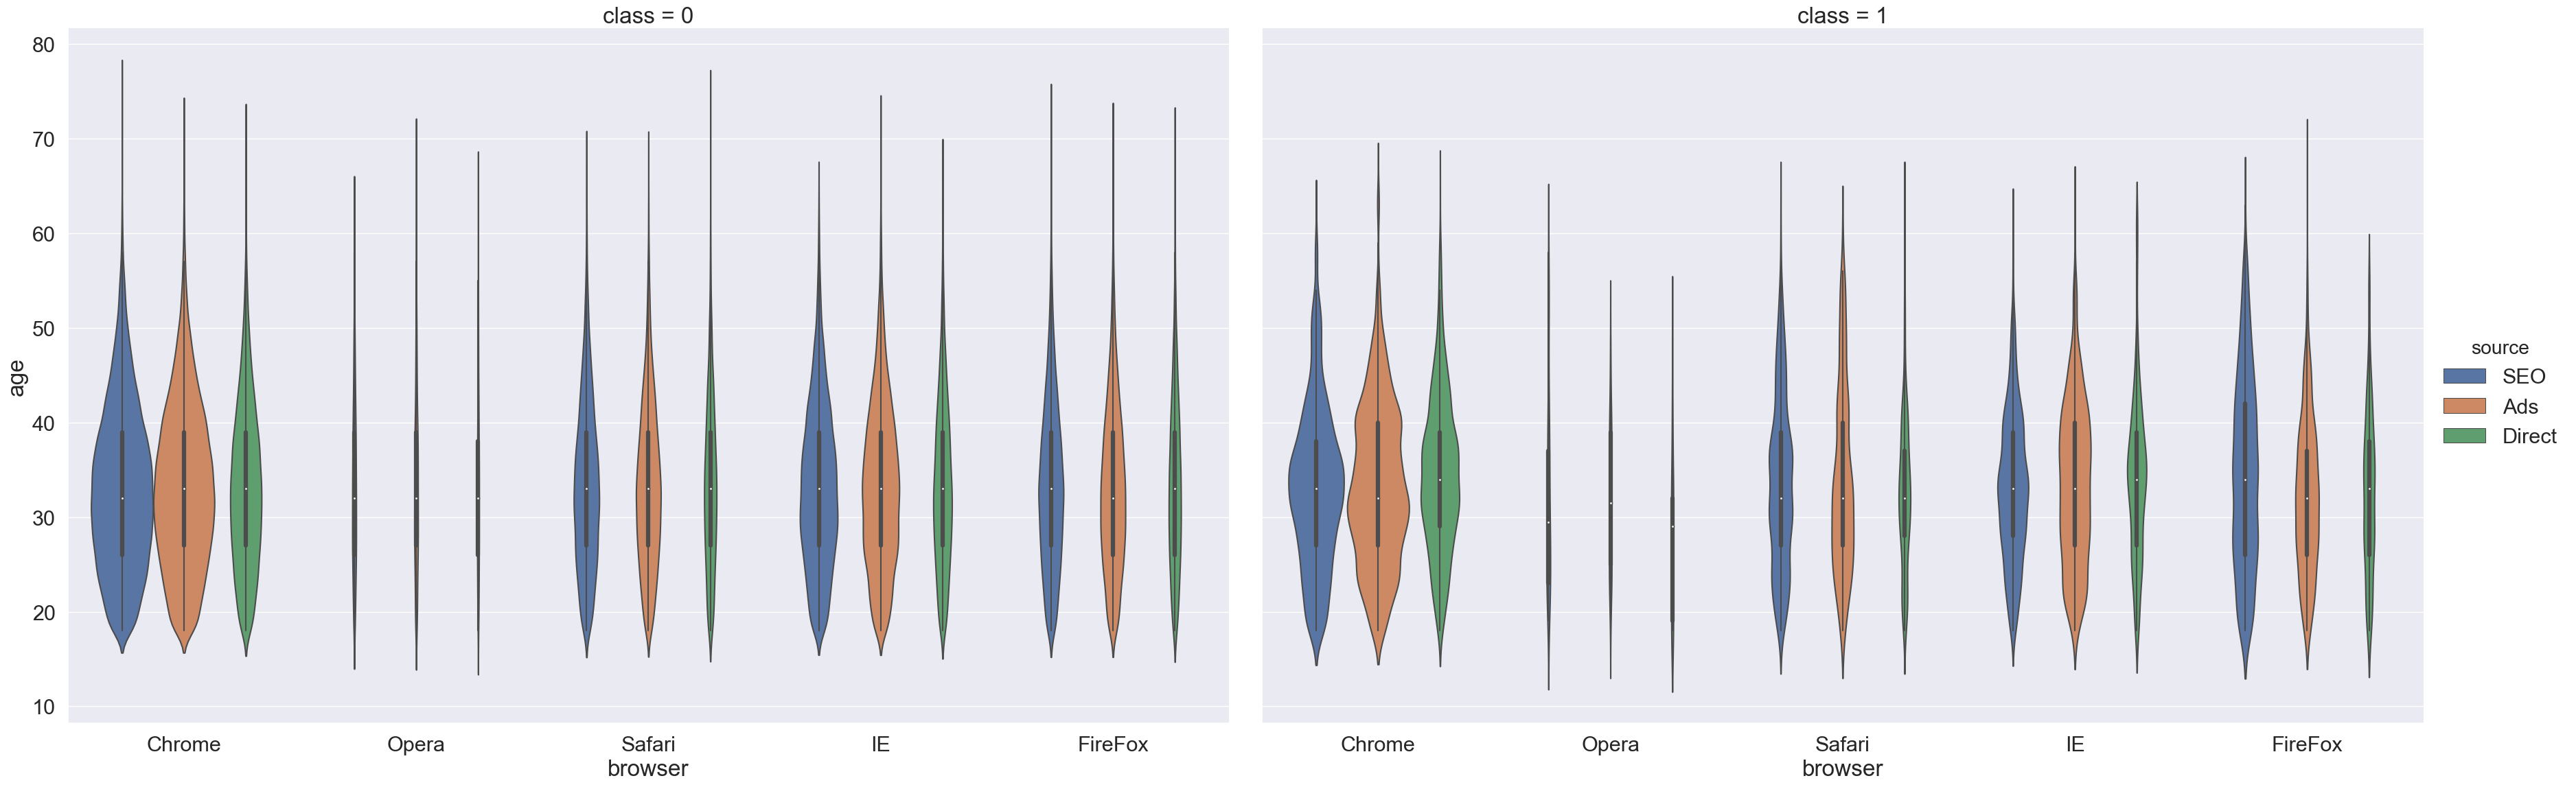

In [1039]:
sns.set(font_scale=2)
sns.catplot(col="class",x="browser", y="age", hue="source",data=Fraud_data, kind="violin",height=12,aspect=1.5,scale='count',scale_hue=False)


### Categorical Distribution Output Summary

### 1) The catplot seems to suggest there is an even distribution of browser and source among both classes. There seems to be a wider age distribution of browser firefox and source SEO among the fraudulent class than the non-fraudulent class. Additionally, for Chrome users in the fraudulent class, the age distribution seems to be slightly more centered within age group 25-40 versus the non-fraudulent class. 


## In the case study description, it states that for variable 'device id', one device id is assigned per device and can be used more than once if multiple users purchased products with that device. There is potential that if multiple users use one device, there is an increased risk of fraud. 

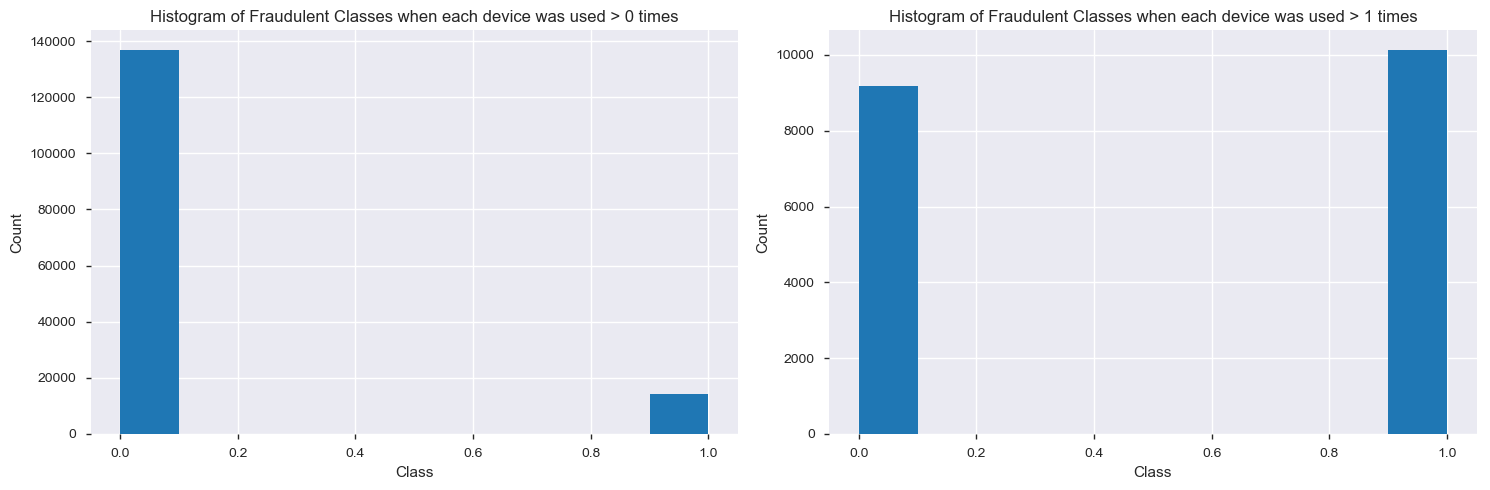

'Distribution of Fraudulent Class in entire dataset: '

0    136961
1     14151
Name: class, dtype: int64

'Distribution of Fraudulent Class amongst devices used more than once: '

1    10141
0     9190
Name: class, dtype: int64

In [795]:
# Distribution of Fraud and Non-Fraud amongst devices that were used either once or multiple times

fig, axes = plt.subplots(1, 2)

for i, ax in enumerate(fig.axes):
    multdevice=Fraud_data['device_id'].value_counts()[Fraud_data['device_id'].value_counts()>i].index
    ax.hist(Fraud_data[Fraud_data['device_id'].isin(multdevice)]['class'])
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title('Histogram of Fraudulent Classes when each device was used > '+str(i)+' times')
    fig.set_size_inches(15,5)
fig.tight_layout()
plt.show()

multdevice=Fraud_data['device_id'].value_counts()[Fraud_data['device_id'].value_counts()>0].index
display("Distribution of Fraudulent Class in entire dataset: ",Fraud_data[Fraud_data['device_id'].isin(multdevice)]['class'].value_counts())
print('\n\n\n\n')
multdevice=Fraud_data['device_id'].value_counts()[Fraud_data['device_id'].value_counts()>1].index
display("Distribution of Fraudulent Class amongst devices used more than once: ",Fraud_data[Fraud_data['device_id'].isin(multdevice)]['class'].value_counts())

## Multiple Device Output Summary

### The previous two histograms indicate that the majority of purchases labeled as fraudulent were conducted on devices that were used multiple times. Additionally, only 6.71% of all non-fraudulent purchases were conducted on devices that were used multiple times. As a result, A binary variable will be added to the dataset that indicates whether or not a device was used multiple times. 

In [792]:
Fraud_data["Multi-Use Device"]=1*Fraud_data['device_id'].isin(multdevice)

In [793]:
# Correlation table
Fraud_data.corr()

,user_id,purchase_value,age,ip_address,class,delta_time_minutes,DayOfYear,Multi-Use Device
user_id,1.000000,0.002617,0.000611,-0.003144,0.001945,-0.001042,-0.000567,-0.000486
purchase_value,0.002617,1.000000,0.002370,-0.000328,0.001011,0.003441,0.005494,0.000927
age,0.000611,0.002370,1.000000,0.001140,0.006624,-0.000575,-0.003392,0.007796
ip_address,-0.003144,-0.000328,0.001140,1.000000,-0.005208,0.003387,0.002350,-0.002253
class,0.001945,0.001011,0.006624,-0.005208,1.000000,-0.257888,-0.323204,0.566548
delta_time_minutes,-0.001042,0.003441,-0.000575,0.003387,-0.257888,1.000000,0.549551,-0.217983
DayOfYear,-0.000567,0.005494,-0.003392,0.002350,-0.323204,0.549551,1.000000,-0.291707
Multi-Use Device,-0.000486,0.000927,0.007796,-0.002253,0.566548,-0.217983,-0.291707,1.000000


## The three features that were created, "delta_time_minutes", "DayOfYear", and "Multi-Use Device", seem to have a significant effect on the outcome class with correlation coefficients of -0.257, -0.323, and 0.566, respectively, This indicates that we may have found strong predictors of Fraud. 

# Creating Predictive Model 

In [886]:
#In order to begin using categorical variables for logistic regression, categorical variables will be converted to dummy variables via One Hot Encoding. 

One_Hot_Encoding=pd.get_dummies(Fraud_data[['browser','source','sex','country']],drop_first = True)

#Attaching transformed dataframe with numeric dataframe

Trans_Fraud_data= pd.concat([Fraud_data[Fraud_data.columns.drop(['browser','source','sex','country'])],One_Hot_Encoding],axis=1)
print('Original Data shape: ',Fraud_data.shape)
print("Shape of data with One-Hot_Encoded categories: ",One_Hot_Encoding.shape)
print("Final Dataframe Shape minus 4 original categorical columns: ",Trans_Fraud_data.shape)

Original Data shape:  (151112, 15)
Shape of data with One-Hot_Encoded categories:  (151112, 43)
Final Dataframe Shape minus 4 original categorical columns:  (151112, 54)


In [927]:
#Dropping columns that will not be used as predictors for analysis:
Predictors=list(Trans_Fraud_data.columns.drop(['user_id','class','signup_time','purchase_time','device_id','ip_address']))
Outcome = 'class'


X_train, X_test, y_train, y_test = train_test_split(Trans_Fraud_data[Predictors], Trans_Fraud_data[Outcome], test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(120889, 48) (120889,)
(30223, 48) (30223,)


In [1223]:
#Variables that will be used for analysis
Trans_Fraud_data[Predictors].columns

Index(['purchase_value', 'age', 'delta_time_minutes', 'DayOfYear',
       'Multi-Use Device', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'source_Direct', 'source_SEO', 'sex_M',
       'country_Australia', 'country_Austria', 'country_Belgium',
       'country_Brazil', 'country_Canada', 'country_Chile', 'country_China',
       'country_Colombia', 'country_Denmark', 'country_Finland',
       'country_France', 'country_Germany', 'country_Hong Kong',
       'country_India', 'country_Indonesia', 'country_Italy', 'country_Japan',
       'country_Korea Republic of', 'country_Mexico', 'country_Missing',
       'country_Netherlands', 'country_Norway', 'country_Other',
       'country_Poland', 'country_Romania', 'country_Russian Federation',
       'country_South Africa', 'country_Spain', 'country_Sweden',
       'country_Switzerland', 'country_Taiwan; Republic of China (ROC)',
       'country_Turkey', 'country_Ukraine', 'country_United Kingdom',
       'country_Un

In [906]:
#Function to predict best threshold for AUC

def getthreshold(y_test, predict_test):
    best_roc = 0 
    best_threshold = 0
    best_fpr = []
    best_tpr = []
    for threshold in np.arange(0, 1, 0.001):
        pred_binary = predict_test.apply(lambda x: 1 if x >= threshold else 0)
        fpr, tpr, thresholds =roc_curve(y_test, pred_binary)
        roc_auc = auc(fpr, tpr)
        if roc_auc > best_roc:
            best_roc = roc_auc
            best_threshold = threshold 
            best_fpr = fpr 
            best_tpr = tpr

    return round(best_roc,2), round(best_threshold,2), best_fpr, best_tpr

In [919]:
print("Distribution of outcomes in train:\n", pd.value_counts(y_train))
print("Distribution of outcomes in test:\n", pd.value_counts(y_test))

Distribution of outcomes in train:
 0    109580
1     11309
Name: class, dtype: int64
Distribution of outcomes in test:
 0    27381
1     2842
Name: class, dtype: int64


## Baseline Logistic Regression

Optimization terminated successfully.
         Current function value: 0.189869
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:               120889
Model:                          Logit   Df Residuals:                   120841
Method:                           MLE   Df Model:                           47
Date:                Sun, 23 Jun 2019   Pseudo R-squ.:                  0.3893
Time:                        02:01:06   Log-Likelihood:                -22953.
converged:                       True   LL-Null:                       -37586.
                                        LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
purchase_value                             -0.0013

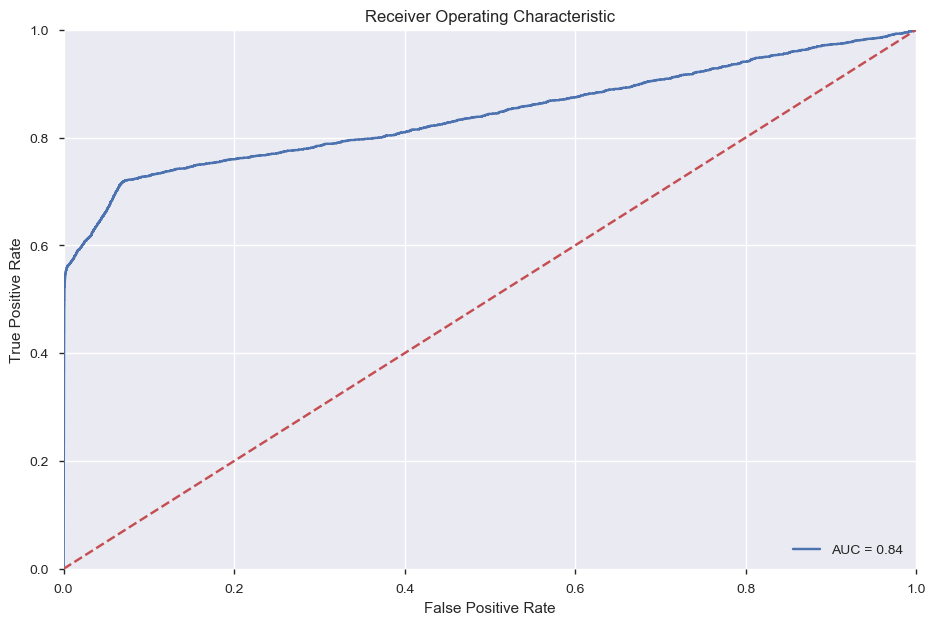

In [1001]:

      

# Fitting the model
sm_model = sm.Logit(endog = y_train , exog = X_train)
sm_model_result = sm_model.fit(method='newton',maxiter = 3000, disp=True)
predict = sm_model_result.predict(X_train)
predict_test = sm_model_result.predict(X_test)
print(sm_model_result.summary())
        

############################################ Output Results
roc_auc, best_threshold, fpr, tpr = getthreshold(y_test, predict_test)

#print(roc_auc, best_threshold, best_fpr, best_tpr)
#model_pred = pd.Dataframe(model_pred)
predict_test_binary = predict_test.apply(lambda x: 1 if x >= best_threshold else 0)   
print("\nFor Test data:\n")
print("AOC ROC:", round(metrics.roc_auc_score(y_test, predict_test_binary, average = 'micro'),2))
print("Best Threshold:", round(best_threshold,2))
print("F1-Score: %3.2f" %metrics.f1_score(y_test,predict_test_binary,average = 'binary'))
print('Accuracy: %3.2f' % metrics.accuracy_score(y_test, predict_test_binary))
print("Classification Report:\n",classification_report(y_test, predict_test_binary))
print("Confusion Matrix:\n",confusion_matrix(y_test, predict_test_binary, labels =[0, 1]))


########################################### Metrics
fpr, tpr, thresholds = roc_curve(y_train, predict)
roc_auc = auc(fpr, tpr)
print("******Area under the curve TRAIN: Using probabiltiies *******", round(roc_auc,3))

fpr, tpr, thresholds = roc_curve(y_test, predict_test)
roc_auc = auc(fpr, tpr)
roc_valid = pd.DataFrame(columns = [fpr, tpr, thresholds])
print("******Area under the curve VALID: Using probabilties *******", round(roc_auc,3))
# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.rcParams["figure.figsize"] = (11,7)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Baseline model output summary

### 1) Given the class imbalance inherent in the dataset, obtaining an AUC ROC of 0.82 is satisfactory and serves as an excellent baseline. Given the classification report, it seems there is a recall of 0.72 on the positive class while there is a precision of 0.51. Given the nature of the problem, recall is the more important metric to optimize. Recall informs how well the model is able to predict fraud, given that the specific purchase is fraudulent. Precision is a measure of how well the model is able to rightfully predict fraud, given that it predicted fraud. In other words, it may predict fraud on the negative class but it may be a false alarm. It is more important to be able to detect fraud when fraud is present than erring on the side of caution and predicting fraud when there is no fraud. 

### 2) Accuracy is 0.91 on the test set. Although this may seem impressive at first glance, it can be purely an artificact of the severe class imbalance. If the model predicted "No Fraud" on all data points, the accuracy would be 91%.

### 3) All but 3 variables had a p-value less than 0.05 (I am rounding down the p-value for "purchase_value" variable). The variables that were derived variables were considered extremely important, with the most important variable being "Multi-Use Device". Although delta_time_minutes was also a significant variable, the coefficient is only  -6.237e-06. However, the coefficient is small due to the fact that the magnitudes of the values within this variable are very large (max value is 172799)

In [1013]:
print("If model predicted No Fraud for all purchases, model would be correct ",sum(y_test==0)/len(y_test)*100," percent of the time")

If model predicted No Fraud for all purchases, model would be correct  90.6395791284783  percent of the time


## Logistic Regression with lasso regularization

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.192042768752434
            Iterations: 411
            Function evaluations: 428
            Gradient evaluations: 411
QC check did not pass for 9 out of 48 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:               120889
Model:                          Logit   Df Residuals:                   120841
Method:                           MLE   Df Model:                           47
Date:                Sun, 23 Jun 2019   Pseudo R-squ.:                  0.3875
Time:                        21:50:37   Log-Likelihood:                -23020.
converged:                       True   LL-Null:           

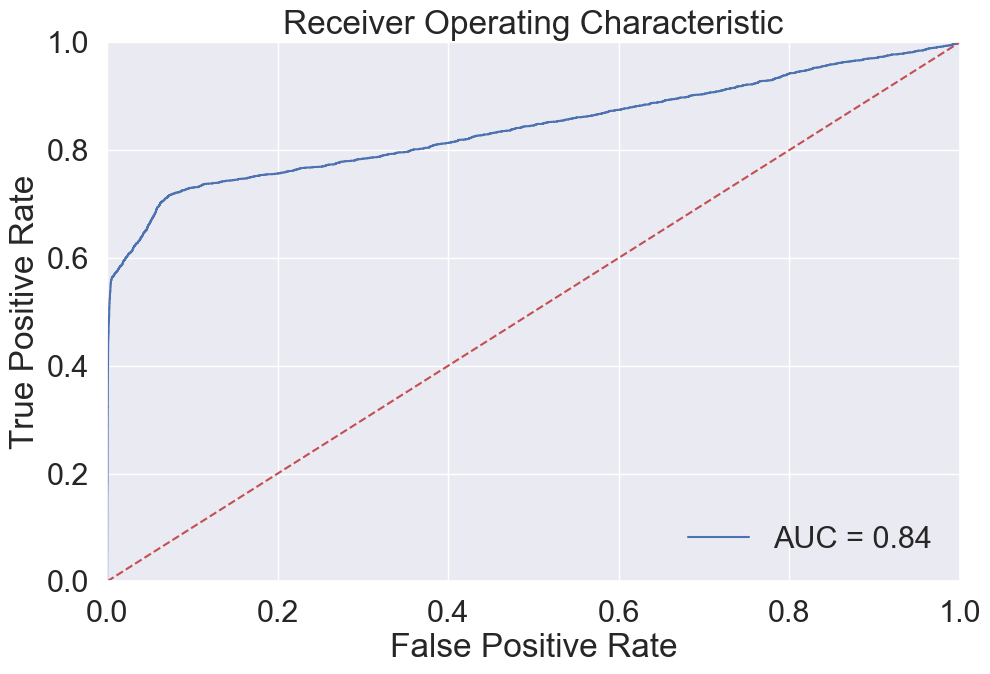

In [1077]:

    # Fitting the model
sm_model = sm.Logit(endog = y_train , exog = X_train)
sm_model_result = sm_model.fit_regularized(method = 'l1',maxiter = 6000, disp=True,alpha=5)
predict = sm_model_result.predict(X_train)
predict_test = sm_model_result.predict(X_test)
print(sm_model_result.summary())
        

############################################ Output Results
roc_auc, best_threshold, fpr, tpr = getthreshold(y_test, predict_test)

#print(roc_auc, best_threshold, best_fpr, best_tpr)
#model_pred = pd.Dataframe(model_pred)
predict_test_binary = predict_test.apply(lambda x: 1 if x >= best_threshold else 0)   
print("\nFor Test data:\n")
print("AOC ROC:", round(metrics.roc_auc_score(y_test, predict_test_binary, average = 'micro'),2))
print("Best Threshold:", round(best_threshold,2))
print("F1-Score: %3.2f" %metrics.f1_score(y_test,predict_test_binary,average = 'binary'))
print('Accuracy: %3.2f' % metrics.accuracy_score(y_test, predict_test_binary))
print("Classification Report:\n",classification_report(y_test, predict_test_binary))
print("Confusion Matrix:\n",confusion_matrix(y_test, predict_test_binary, labels =[0, 1]))


########################################### Metrics
fpr, tpr, thresholds = roc_curve(y_train, predict)
roc_auc = auc(fpr, tpr)
print("******Area under the curve TRAIN: Using probabiltiies *******", round(roc_auc,3))

fpr, tpr, thresholds = roc_curve(y_test, predict_test)
roc_auc = auc(fpr, tpr)
roc_valid = pd.DataFrame(columns = [fpr, tpr, thresholds])
print("******Area under the curve VALID: Using probabilties *******", round(roc_auc,3))
# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.rcParams["figure.figsize"] = (11,7)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Output Summary

### 1) L1 lasso regularization did not improve results. Increasing the alpha regularization coefficient only worsens the model. This indicates that the variables present in the baseline model are strong predictors. 

## Baseline Random Forest


For Test data:

AOC ROC: 0.81
F1-Score: 0.58
Accuracy: 0.91
Best Threshold: 0.13
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     27394
           1       0.50      0.70      0.58      2829

   micro avg       0.91      0.91      0.91     30223
   macro avg       0.73      0.81      0.77     30223
weighted avg       0.92      0.91      0.91     30223

Confusion Matrix:
 [[25427  1967]
 [  853  1976]]
******Area under the curve TRAIN: Using probabiltiies ******* 1.0
******Area under the curve VALID: Using probabilties ******* 0.842


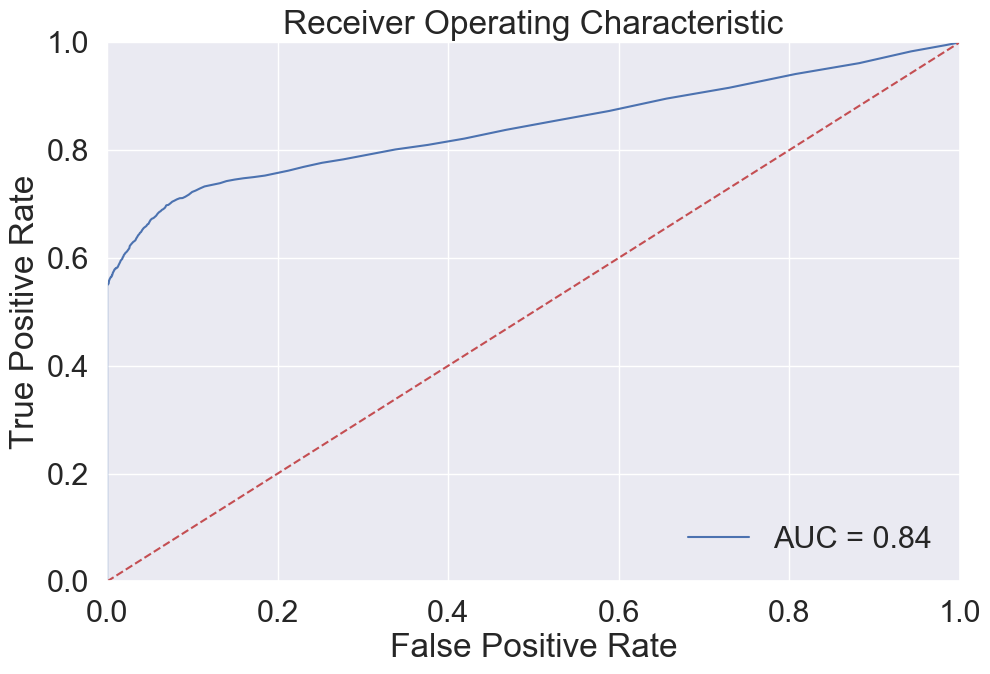

In [1089]:
#Attempt to improve model with random forest classifier
clf=RandomForestClassifier(n_estimators=300)

# Fitting the model
rf= clf.fit(X_train,y_train)
predict = rf.predict(X_train)
predict_test = rf.predict(X_test)

        

###########b################################# Output Results
roc_auc, best_threshold, fpr, tpr = getthreshold(y_test, pd.DataFrame(rf.predict_proba(X_test))[1])
predict_test_binary = pd.DataFrame(rf.predict_proba(X_test))[1].apply(lambda x: 1 if x >= best_threshold else 0)   
print("\nFor Test data:\n")
print("AOC ROC:", round(metrics.roc_auc_score(y_test, predict_test_binary, average = 'micro'),2))
print("F1-Score: %3.2f" %metrics.f1_score(y_test,predict_test_binary,average = 'binary'))
print('Accuracy: %3.2f' % metrics.accuracy_score(y_test, predict_test_binary))
print("Best Threshold:", round(best_threshold,2))
print("Classification Report:\n",classification_report(y_test, predict_test_binary))
print("Confusion Matrix:\n",confusion_matrix(y_test, predict_test_binary, labels =[0, 1]))


########################################### Metrics
fpr, tpr, thresholds = roc_curve(y_train, pd.DataFrame(rf.predict_proba(X_train))[1])
roc_auc = auc(fpr, tpr)
print("******Area under the curve TRAIN: Using probabiltiies *******", round(roc_auc,3))

fpr, tpr, thresholds = roc_curve(y_test, pd.DataFrame(rf.predict_proba(X_test))[1])
roc_auc = auc(fpr, tpr)
roc_valid = pd.DataFrame(columns = [fpr, tpr, thresholds])
print("******Area under the curve VALID: Using probabilties *******", round(roc_auc,3))
# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.rcParams["figure.figsize"] = (11,7)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest Output Summary

### Random forest classifier resulted in a recall of 0.70 on the test class, which is slightly worse than the baseline logistic regression. 

## Logistic Regression with oversample with SMOTE method

Optimization terminated successfully.
         Current function value: 0.416386
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               219134
Model:                          Logit   Df Residuals:                   219086
Method:                           MLE   Df Model:                           47
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:                  0.3993
Time:                        08:12:43   Log-Likelihood:                -91244.
converged:                       True   LL-Null:                   -1.5189e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0012      0.000     -3.693      0.000      -0.002      -0.001
x2            -0.0018      0.

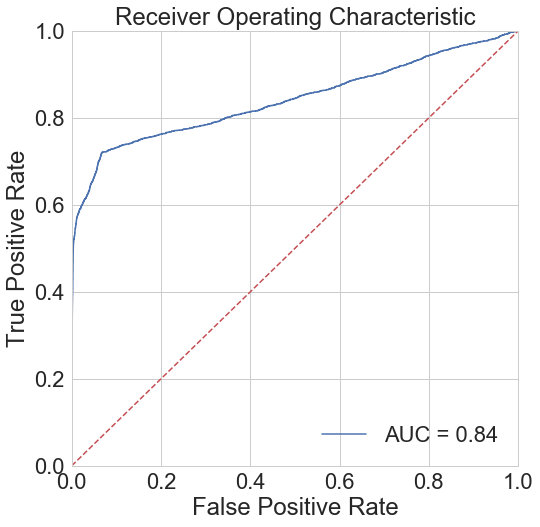

In [1154]:
#Oversample the Fraud class to balance the output class. 

sm1 = SMOTE(random_state=27, ratio=1.0)
X_train_2, y_train_2 = sm1.fit_sample(X_train, y_train)



      

# Fitting the model
sm_model = sm.Logit(endog = y_train_2 , exog = X_train_2)
sm_model_result = sm_model.fit(method='newton',maxiter = 3000, disp=True)
predict = sm_model_result.predict(X_train_2)
predict_test = sm_model_result.predict(X_test)
print(sm_model_result.summary())
        

############################################ Output Results
roc_auc, best_threshold, fpr, tpr = getthreshold(y_test, predict_test)

#print(roc_auc, best_threshold, best_fpr, best_tpr)
#model_pred = pd.Dataframe(model_pred)
predict_test_binary = predict_test.apply(lambda x: 1 if x >= best_threshold else 0)   
print("\nFor Test data:\n")
print("AOC ROC:", round(metrics.roc_auc_score(y_test, predict_test_binary, average = 'micro'),2))
print("Best Threshold:", round(best_threshold,2))
print("F1-Score: %3.2f" %metrics.f1_score(y_test,predict_test_binary,average = 'binary'))
print('Accuracy: %3.2f' % metrics.accuracy_score(y_test, predict_test_binary))
print("Classification Report:\n",classification_report(y_test, predict_test_binary))
print("Confusion Matrix:\n",confusion_matrix(y_test, predict_test_binary, labels =[0, 1]))


########################################### Metrics
fpr, tpr, thresholds = roc_curve(y_train_2, predict)
roc_auc = auc(fpr, tpr)
print("******Area under the curve TRAIN: Using probabiltiies *******", round(roc_auc,3))

fpr, tpr, thresholds = roc_curve(y_test, predict_test)
roc_auc = auc(fpr, tpr)
roc_valid = pd.DataFrame(columns = [fpr, tpr, thresholds])
print("******Area under the curve VALID: Using probabilties *******", round(roc_auc,3))
# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.rcParams["figure.figsize"] = (11,7)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Logistic Regression with oversampling with resample method

In [1188]:
not_fraud = X_train[y_train==0]
fraud = X_train[y_train==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) 

# combine majority and upsampled minority
X_train_3 = pd.concat([not_fraud, fraud_upsampled])
X_train_3.reset_index(drop=True,inplace=True)

oversampled_Y=pd.Series(np.squeeze(np.ones((fraud_upsampled.shape[0]-fraud.shape[0],1)),axis=1))    #Appending oversampled minority class to data
y_train_3 = y_train.append(oversampled_Y)
y_train_3.reset_index(drop=True,inplace=True)


print("Oversampled Data Size: ",fraud_upsampled.shape)
print("Size of Majority Class ",not_fraud.shape)
print("Size of Transformed Data: ",X_train_3.shape)
print("Size of Transformed outcome class: ",y_train_3.shape)

Oversampled Data Size:  (109567, 48)
Size of Majority Class  (109567, 48)
Size of Transformed Data:  (219134, 48)
Size of Transformed outcome class:  (219134,)


Optimization terminated successfully.
         Current function value: 0.532493
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               219134
Model:                          Logit   Df Residuals:                   219086
Method:                           MLE   Df Model:                           47
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:                  0.2318
Time:                        08:34:24   Log-Likelihood:            -1.1669e+05
converged:                       True   LL-Null:                   -1.5189e+05
                                        LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
purchase_value                             -0.0008

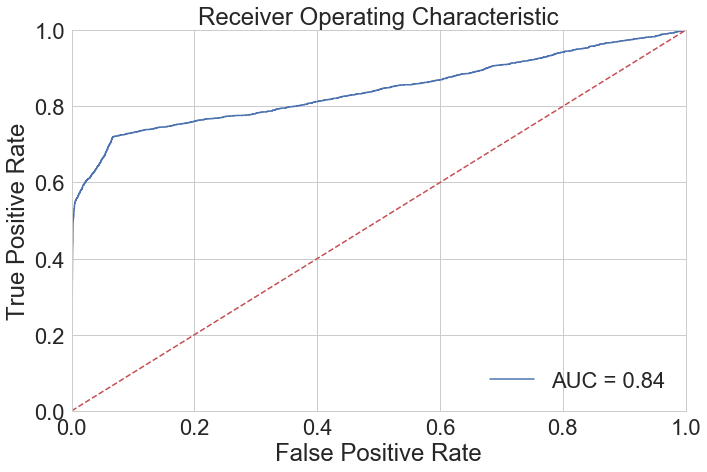

In [1190]:

      

# Fitting the model
sm_model = sm.Logit(endog = y_train_3 , exog = X_train_3)
sm_model_result = sm_model.fit(method='newton',maxiter = 3000, disp=True)
predict = sm_model_result.predict(X_train_3)
predict_test = sm_model_result.predict(X_test)
print(sm_model_result.summary())
        

############################################ Output Results
roc_auc, best_threshold, fpr, tpr = getthreshold(y_test, predict_test)

#print(roc_auc, best_threshold, best_fpr, best_tpr)
#model_pred = pd.Dataframe(model_pred)
predict_test_binary = predict_test.apply(lambda x: 1 if x >= best_threshold else 0)   
print("\nFor Test data:\n")
print("AOC ROC:", round(metrics.roc_auc_score(y_test, predict_test_binary, average = 'micro'),2))
print("Best Threshold:", round(best_threshold,2))
print("F1-Score: %3.2f" %metrics.f1_score(y_test,predict_test_binary,average = 'binary'))
print('Accuracy: %3.2f' % metrics.accuracy_score(y_test, predict_test_binary))
print("Classification Report:\n",classification_report(y_test, predict_test_binary))
print("Confusion Matrix:\n",confusion_matrix(y_test, predict_test_binary, labels =[0, 1]))


########################################### Metrics
fpr, tpr, thresholds = roc_curve(y_train_3, predict)
roc_auc = auc(fpr, tpr)
print("******Area under the curve TRAIN: Using probabiltiies *******", round(roc_auc,3))

fpr, tpr, thresholds = roc_curve(y_test, predict_test)
roc_auc = auc(fpr, tpr)
roc_valid = pd.DataFrame(columns = [fpr, tpr, thresholds])
print("******Area under the curve VALID: Using probabilties *******", round(roc_auc,3))
# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.rcParams["figure.figsize"] = (11,7)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Summary

### 1) The output of logistic regression with oversampling indicates that there was no change to recall from the baseline model. However, the precision on the positive class increased from 0.50 to 0.53, which indicates that less of the negative class is being improperly classified as fraud. 


For Test data:

AOC ROC: 0.8
F1-Score: 0.55
Accuracy: 0.89
Best Threshold: 0.27
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     27394
           1       0.45      0.68      0.55      2829

   micro avg       0.89      0.89      0.89     30223
   macro avg       0.71      0.80      0.74     30223
weighted avg       0.92      0.89      0.90     30223

Confusion Matrix:
 [[25072  2322]
 [  892  1937]]
******Area under the curve TRAIN: Using probabiltiies ******* 0.967
******Area under the curve VALID: Using probabilties ******* 0.833


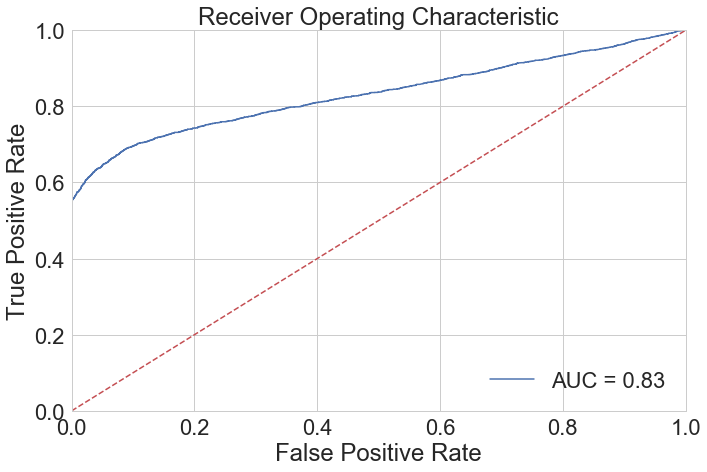

In [1192]:
#Random Forest with oversampling

#Attempt to improve model with random forest classifier
clf=RandomForestClassifier(n_estimators=300)

# Fitting the model
rf= clf.fit(X_train_3,y_train_3)
predict = rf.predict(X_train_3)
predict_test = rf.predict(X_test)

        

###########b################################# Output Results
roc_auc, best_threshold, fpr, tpr = getthreshold(y_test, pd.DataFrame(rf.predict_proba(X_test))[1])
predict_test_binary = pd.DataFrame(rf.predict_proba(X_test))[1].apply(lambda x: 1 if x >= best_threshold else 0)   
print("\nFor Test data:\n")
print("AOC ROC:", round(metrics.roc_auc_score(y_test, predict_test_binary, average = 'micro'),2))
print("F1-Score: %3.2f" %metrics.f1_score(y_test,predict_test_binary,average = 'binary'))
print('Accuracy: %3.2f' % metrics.accuracy_score(y_test, predict_test_binary))
print("Best Threshold:", round(best_threshold,2))
print("Classification Report:\n",classification_report(y_test, predict_test_binary))
print("Confusion Matrix:\n",confusion_matrix(y_test, predict_test_binary, labels =[0, 1]))


########################################### Metrics
fpr, tpr, thresholds = roc_curve(y_train_3, pd.DataFrame(rf.predict_proba(X_train_3))[1])
roc_auc = auc(fpr, tpr)
print("******Area under the curve TRAIN: Using probabiltiies *******", round(roc_auc,3))

fpr, tpr, thresholds = roc_curve(y_test, pd.DataFrame(rf.predict_proba(X_test))[1])
roc_auc = auc(fpr, tpr)
roc_valid = pd.DataFrame(columns = [fpr, tpr, thresholds])
print("******Area under the curve VALID: Using probabilties *******", round(roc_auc,3))
# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.rcParams["figure.figsize"] = (11,7)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest with class weights

In [1226]:
#Attempt to improve model with random forest classifier
clf=RandomForestClassifier(n_estimators=300,class_weight= 'balanced')

# Fitting the model
rf= clf.fit(X_train,y_train)
predict = rf.predict(X_train)
predict_test = rf.predict(X_test)

        

###########b################################# Output Results
roc_auc, best_threshold, fpr, tpr = getthreshold(y_test, pd.DataFrame(rf.predict_proba(X_test))[1])
predict_test_binary = pd.DataFrame(rf.predict_proba(X_test))[1].apply(lambda x: 1 if x >= best_threshold else 0)   
print("\nFor Test data:\n")
print("AOC ROC:", round(metrics.roc_auc_score(y_test, predict_test_binary, average = 'micro'),2))
print("F1-Score: %3.2f" %metrics.f1_score(y_test,predict_test_binary,average = 'binary'))
print('Accuracy: %3.2f' % metrics.accuracy_score(y_test, predict_test_binary))
print("Best Threshold:", round(best_threshold,2))
print("Classification Report:\n",classification_report(y_test, predict_test_binary))
print("Confusion Matrix:\n",confusion_matrix(y_test, predict_test_binary, labels =[0, 1]))


########################################### Metrics
fpr, tpr, thresholds = roc_curve(y_train, pd.DataFrame(rf.predict_proba(X_train))[1])
roc_auc = auc(fpr, tpr)
print("******Area under the curve TRAIN: Using probabiltiies *******", round(roc_auc,3))

fpr, tpr, thresholds = roc_curve(y_test, pd.DataFrame(rf.predict_proba(X_test))[1])
roc_auc = auc(fpr, tpr)
roc_valid = pd.DataFrame(columns = [fpr, tpr, thresholds])
print("******Area under the curve VALID: Using probabilties *******", round(roc_auc,3))



For Test data:

AOC ROC: 0.81
F1-Score: 0.57
Accuracy: 0.90
Best Threshold: 0.11
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     27394
           1       0.47      0.71      0.57      2829

   micro avg       0.90      0.90      0.90     30223
   macro avg       0.72      0.81      0.76     30223
weighted avg       0.92      0.90      0.91     30223

Confusion Matrix:
 [[25159  2235]
 [  823  2006]]
******Area under the curve TRAIN: Using probabiltiies ******* 1.0
******Area under the curve VALID: Using probabilties ******* 0.845


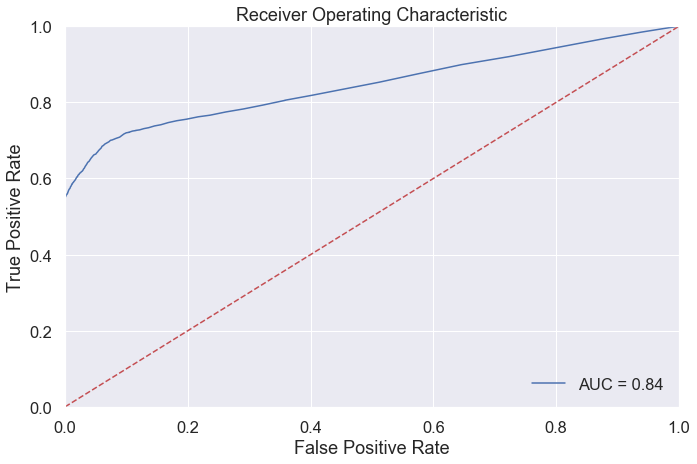

In [1225]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.rcParams["figure.figsize"] = (12,7)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusion

### 1) The logistic regression model with oversampling was our best model with a recall of 0.72 and precision of 0.53. Given the class imbalance that was inherent in the dataset, this is a satisfactory metric. Future iterations would involve using boosting methods like adaboost. 

### 2) Random forests was inferior to logistic regression, even with class weights and oversampling. The best random forest model resulted in a recall of 0.71 and a precision of 0.47. 


### 3) Lasso regularization on the baseline logistic regression negatively impacted the overall model